In [7]:
import numpy as np
import random

x = np.random.normal(loc= 300.0, size=1000)

print (np.mean(x))

300.0377420671269


In [6]:
sample_mean = []

for i in range(50):
  y = random.sample(x.tolist(), 4)
  avg = np.mean(y)
  sample_mean.append(avg)

print(np.mean(sample_mean))

300.0039920326751


In [2]:
from typing import Tuple, Dict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [4]:
def make_bootstraps(data: np.array, n_bootstraps: int=100) -> Dict[str, Dict[str, np.array]]:
    """
    Function to generate bootstrapped samples

    Inputs:
        data         -> array of input data
        n_bootstraps -> integer number of bootstraps to produce

    Outputs:
        {'boot_n': {'boot': np.array, 'test': np.array}} -> dictionary of dictionaries containing 
                                                            the bootstrap samples & out-of-bag test sets
    """

    # initialize output dictionary, unique value count, sample size, & list of indices
    dc       = {}
    n_unival = 0
    sample_size = data.shape[0]
    idx = [i for i in range(sample_size)]
    # loop through the required number of bootstraps
    for b in range(n_bootstraps):
        # obtain boostrap samples with replacement
        sidx   = np.random.choice(idx,replace=True,size=sample_size)
        b_samp = data[sidx,:]
        # compute number of unique values contained in the bootstrap sample
        n_unival += len(set(sidx))
        # obtain out-of-bag samples for the current b
        oob_idx = list(set(idx) - set(sidx))
        t_samp = np.array([])
        if oob_idx:
            t_samp = data[oob_idx,:]
        # store results
        dc['boot_'+str(b)] = {'boot':b_samp,'test':t_samp}
    # state the mean number of unique values in the bootstraps
    print('Mean number of unique values in each bootstrap: {:.2f}'.format(n_unival/n_bootstraps))
    # return the bootstrap results
    return(dc)

In [5]:
def prediction_error_by_training_size(train: np.array,
                                      test: np.array,
                                      train_sizes: list,
                                      iters: int=10) -> Tuple[list, list]:
    """
    Function to determine the relationship between model performance & training size

    Inputs:
        train       -> array containing training data
        test        -> array containing test data
        train_sizes -> list containing the integer number of samples to be used in the training set
        iters       -> number of repetitions to be done for each training size

    Outputs:
        (list,list) -> a tuple of two lists containing the average MAE and MSE errors for each train_sizes element
    """
    # initialize model & output lists
    lr    = LinearRegression()
    maes  = []
    mses  = []
    # get list of row indexes
    idx = [i for i in range(train.shape[0])]
    # loop over each training size
    for ts in train_sizes:
        # initialize error metrics
        mae = 0
        mse = 0
        # for each training size, repeat the calculation iters times
        for _ in range(iters):
            # obtain training samples without replacement
            sidx     = np.random.choice(idx,replace=False,size=ts)
            trainset = np.copy(train[sidx,:])
            # fit a linear regression model to the training set
            lr.fit(trainset[:,0].reshape(-1,1),trainset[:,1].reshape(-1,1))
            # generate predictions & calculate error metrics
            yp  = lr.predict(test[:,0].reshape(-1,1))
            mae += mean_absolute_error(test[:,1],yp)
            mse += mean_squared_error(test[:,1],yp)
        # store the mean error metrics over all repetitions
        maes.append(mae/iters)
        mses.append(mse/iters)
    # return error metrics
    return(maes,mses)

In [6]:
x,y,coef = make_regression(n_samples=5000,n_features=1,n_targets=1,coef=True,noise=5.0,bias=1.0,random_state=42)

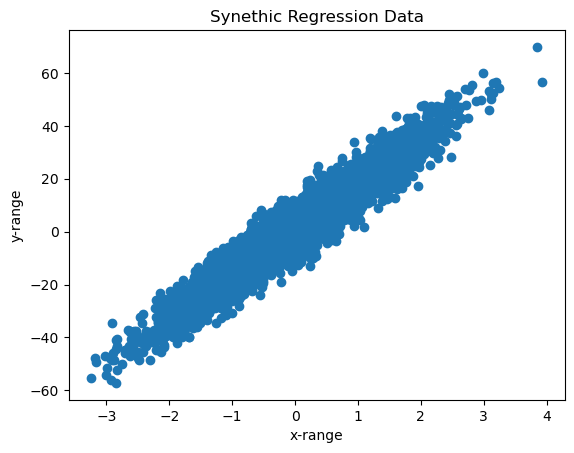

In [7]:
plt.scatter(x,y)
plt.xlabel('x-range')
plt.ylabel('y-range')
plt.title('Synethic Regression Data')
plt.show()

In [8]:
# extract out a small test set to measure performance
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.1, random_state=42)
# define a set of training set sizes to choose from
train_size = [10,20,40,60,80,100,200,300,400]
# package the data
train = np.concatenate((xtrain,ytrain.reshape(-1,1)),axis=1)
test  = np.concatenate((xtest,ytest.reshape(-1,1)),axis=1)
# for each training set size, fit a model and calculate the error
maes,mses = prediction_error_by_training_size(train,test,train_size)

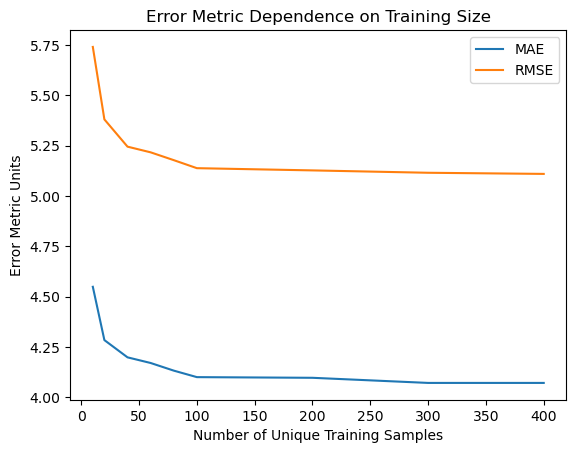

In [9]:
plt.plot(train_size,maes)
plt.plot(train_size,np.sqrt(mses))
plt.title('Error Metric Dependence on Training Size')
plt.xlabel('Number of Unique Training Samples')
plt.ylabel('Error Metric Units')
plt.legend(['MAE','RMSE'])
plt.show()

In [10]:
# package the data
data = np.concatenate((x,y.reshape(-1,1)),axis=1)
# generate bootstrap samples
dcBoot = make_bootstraps(data)

Mean number of unique values in each bootstrap: 3165.00


In [11]:
# initialize storage variables & model
coefs = np.array([])
intrs = np.array([])
maes  = np.array([])
mses  = np.array([])
lr    = LinearRegression()
# loop through each bootstrap sample
for b in dcBoot:
    # fit a linear regression model to the current sample
    lr.fit(dcBoot[b]['boot'][:,0].reshape(-1, 1),dcBoot[b]['boot'][:,1].reshape(-1, 1))
    # store model parameters
    coefs = np.concatenate((coefs,lr.coef_.flatten()))
    intrs = np.concatenate((intrs,lr.intercept_.flatten()))
    # compute the predictions on the out-of-bag test set & compute metrics
    if dcBoot[b]['test'].size:
        yp  = lr.predict(dcBoot[b]['test'][:,0].reshape(-1, 1))
        mae = mean_absolute_error(dcBoot[b]['test'][:,1],yp)
        mse = mean_squared_error(dcBoot[b]['test'][:,1],yp)
        # store the error metrics
        maes = np.concatenate((maes,mae.flatten()))
        mses = np.concatenate((mses,mse.flatten()))

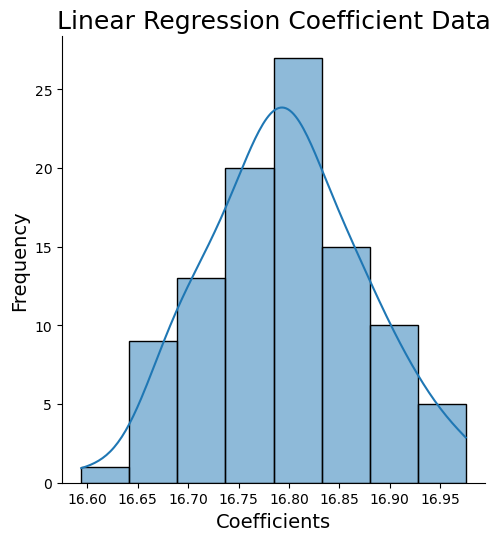

In [12]:
# plot histogram of regression coefficients
sns.displot(coefs, kde=True)
plt.title('Linear Regression Coefficient Data', fontsize=18)
plt.xlabel('Coefficients', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

In [13]:
print('Expected value: {:.2f}'.format(np.mean(coefs)))
print('Estimate Standard Error: {:.2f}'.format(np.std(coefs)/np.sqrt(coefs.shape[0])))
print('99% Confidence Interval for regression coefficient: {0:.2f} - {1:.2f}'.format(np.percentile(coefs,0.5), np.percentile(coefs,99.5)))

Expected value: 16.80
Estimate Standard Error: 0.01
99% Confidence Interval for regression coefficient: 16.62 - 16.97


In [14]:
print('True regression coefficient: {:.2f}'.format(coef))

True regression coefficient: 16.82


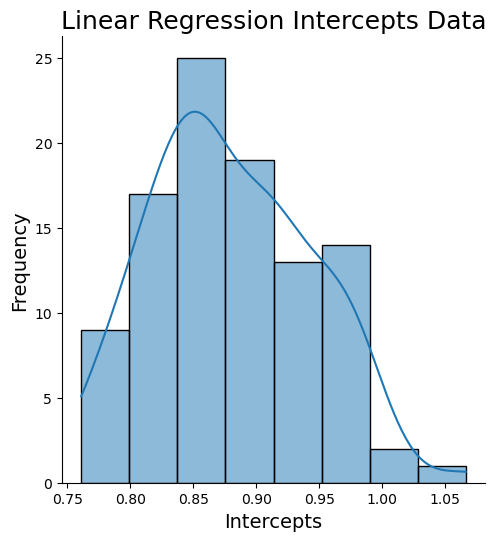

In [15]:
# plot histogram of regression intercepts
sns.displot(intrs, kde=True)
plt.title('Linear Regression Intercepts Data', fontsize=18)
plt.xlabel('Intercepts', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

In [16]:
# compute statistics on model intercept
print('Expected value: {:.2f}'.format(np.mean(intrs)))
print('Estimate Standard Error: {:.2f}'.format(np.std(intrs)/np.sqrt(intrs.shape[0])))
print('99% Confidence Interval for regression intercept: {0:.2f} - {1:.2f}'.format(np.percentile(intrs,0.5),
                                                                                   np.percentile(intrs,99.5)))

Expected value: 0.88
Estimate Standard Error: 0.01
99% Confidence Interval for regression intercept: 0.76 - 1.03


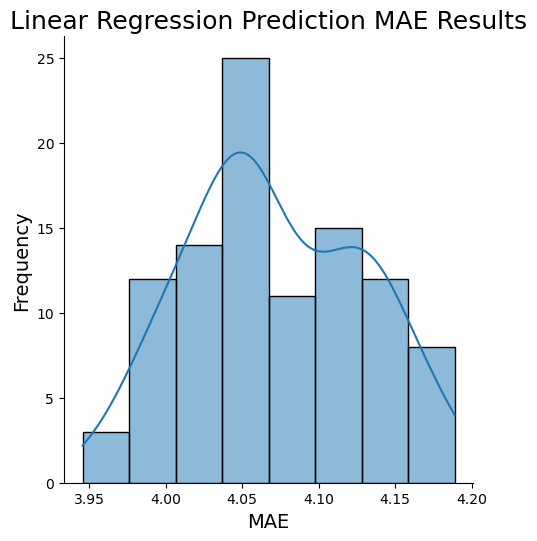

In [17]:
# plot histogram of mae on predictions
sns.displot(maes, kde=True)
plt.title('Linear Regression Prediction MAE Results', fontsize=18)
plt.xlabel('MAE', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

In [18]:
# compute statistics on MAE results
print('Expected value: {:.2f}'.format(np.mean(maes)))
print('Estimate Standard Error: {:.2f}'.format(np.std(maes)/np.sqrt(maes.shape[0])))
print('99% Confidence Interval for Prediction MAE results: {0:.2f} - {1:.2f}'.format(np.percentile(maes,0.5),
                                                                                     np.percentile(maes,99.5)))

Expected value: 4.07
Estimate Standard Error: 0.01
99% Confidence Interval for Prediction MAE results: 3.95 - 4.19


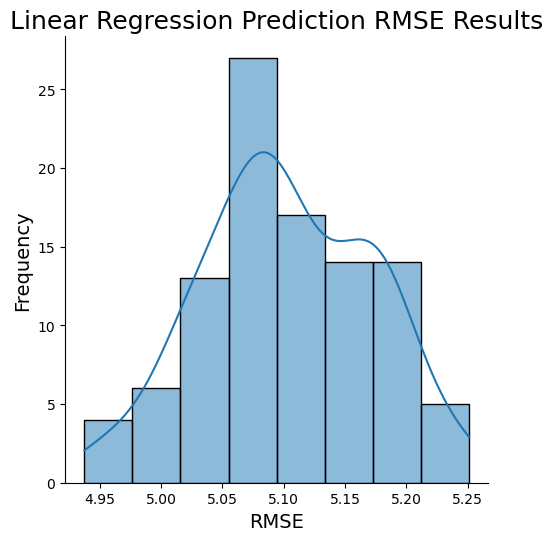

In [19]:
# plot histogram of rmse on predictions
sns.displot(np.sqrt(mses), kde=True)
plt.title('Linear Regression Prediction RMSE Results', fontsize=18)
plt.xlabel('RMSE', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

In [20]:
# compute statistics on RMSE results
rmse = np.sqrt(mses)
print('Expected value: {:.2f}'.format(np.mean(rmse)))
print('Estimate Standard Error: {:.2f}'.format(np.std(rmse)/np.sqrt(rmse.shape[0])))
print('99% Confidence Interval for Prediction RMSE results: {0:.2f} - {1:.2f}'.format(np.percentile(rmse,0.5), np.percentile(rmse,99.5)))

Expected value: 5.10
Estimate Standard Error: 0.01
99% Confidence Interval for Prediction RMSE results: 4.94 - 5.25


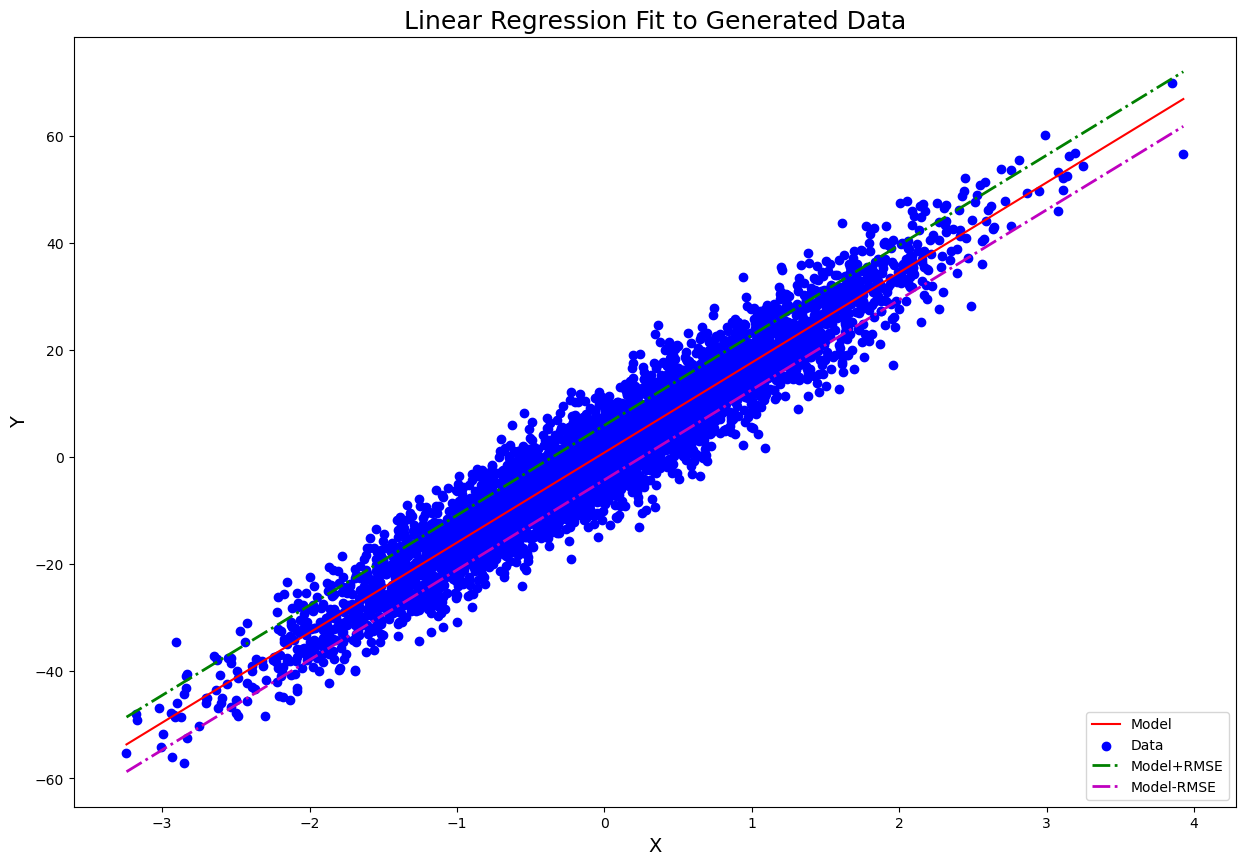

In [21]:
# plot the model against the dataset
xp = np.linspace(min(x),max(x),100)
plt.figure(figsize=(15,10))
plt.plot(xp,np.mean(coef)*xp+np.mean(intrs),color='r')
plt.scatter(x=data[:,0],y=data[:,1],color='b')
plt.plot(xp,np.mean(coef)*xp+np.mean(intrs)+np.mean(np.sqrt(mses)),'-.g',linewidth=2)
plt.plot(xp,np.mean(coef)*xp+np.mean(intrs)-np.mean(np.sqrt(mses)),'-.m',linewidth=2)
plt.title('Linear Regression Fit to Generated Data', fontsize=18)
plt.xlabel('X', fontsize=14)
plt.ylabel('Y', fontsize=14)
plt.legend(['Model','Data','Model+RMSE','Model-RMSE'],loc='lower right')
plt.show()